In [4]:
import pickle
import pandas as pd

with open('beamsearch/' + str(4) + '.pkl', 'rb') as f:
    loaded_results = pickle.load(f)
    conf = loaded_results[0][0]

    df = pd.read_csv('../classifier/top40.csv')
    df = df.groupby('configuration')['time'].sum()

    for c in conf:
        index = df.index.tolist().index(c) if c in df.index else -1
        print(index)
    print(conf)

0
7
32
20
['Default', "{'backbone': 0, 'bump': 1, 'chrono': 1, 'congruence': 0, 'eliminate': 0, 'extract': 0, 'factor': 1, 'fastel': 1, 'forward': 1, 'lucky': 1, 'phase': 1, 'phasesaving': 1, 'preprocess': 1, 'probe': 1, 'randec': 0, 'reluctant': 0, 'reorder': 2, 'rephase': 0, 'restart': 1, 'stable': 0, 'substitute': 1, 'sweep': 1, 'target': 0, 'transitive': 0, 'vivify': 1, 'warmup': 0}", "{'backbone': 2, 'bump': 1, 'chrono': 1, 'congruence': 0, 'eliminate': 1, 'extract': 1, 'factor': 0, 'fastel': 1, 'forward': 0, 'lucky': 1, 'phase': 1, 'phasesaving': 1, 'preprocess': 1, 'probe': 1, 'randec': 1, 'reluctant': 1, 'reorder': 0, 'rephase': 1, 'restart': 1, 'stable': 1, 'substitute': 0, 'sweep': 0, 'target': 1, 'transitive': 1, 'vivify': 0, 'warmup': 0}", "{'backbone': 2, 'bump': 1, 'chrono': 0, 'congruence': 0, 'eliminate': 1, 'extract': 0, 'factor': 1, 'fastel': 1, 'forward': 1, 'lucky': 0, 'phase': 0, 'phasesaving': 1, 'preprocess': 0, 'probe': 0, 'randec': 0, 'reluctant': 0, 'reorder':

In [ ]:
from itertools import combinations
import pandas as pd
from helpers import *
import pickle


"""
Disclaimer: the functions pscore, pscores_all and pscores_ext are slightly modified versions of the functions with the same signatures from Markus Iser's GBD evaluation demo.
Credit for said functions goes to Markus Iser.
https://github.com/Udopia/gbdeval/blob/main/demo_evaluation.md
"""

# Returns VBS performance for a set of instances and a set of configurations.
def pscore(train, solvers: list[str]):
    return getVirtual(train, solvers)

# Returns all portfolios of size k, sorted by VBS performance.
def pscores_all(train, solvers: list[str], k: int):
    return sorted([ (comb, pscore(train, list(comb))) for comb in combinations(solvers, k) ], key=lambda k : k[1])

# For a set of portfolios, extends every portfolio by every remaining solver not yet in the portfolio. Again sorts by VBS performance.
def pscores_ext(train, solvers: list[str], tuples: list[tuple[str]]):
    tupset = set(frozenset(comb + (s,)) for comb in tuples for s in solvers if s not in comb)
    return sorted([(tuple(comb), pscore(train, list(comb))) for comb in tupset ], key=lambda k : k[1])

# Performs beamsearch, using the above functions.
def beamsearch(beam_width, depth, seed=0):
    df = pd.read_csv('top40.csv')
    configs = df['configuration'].drop_duplicates().tolist()

    features = get_available_features()

    data = get_prediction_dataset(features, "family")

    family_counts = data['family'].value_counts()
    families_to_replace = family_counts[family_counts < 5].index

    data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)

    data_train = data, data_test = train_test_split(data, test_size=0.2, random_state=seed, stratify=data["family"])

    hashes = data_train['hash'].tolist()


    p = pscores_all(hashes, configs, 1)[:beam_width]
    portfolios = [p.copy()]
    for i in range(depth - 1):
        print(i)
        p = pscores_ext(hashes, configs, [tup[0] for tup in p])[:beam_width]
        portfolios.append(p.copy())
    return portfolios

results = []
for i in range(10):
    print(i)
    print(beamsearch(1, 20, seed=i))
with open('beamsearch/portfolios.pkl', 'wb') as f:
    pickle.dump(results, f)





0


1
2
3
4
5
6
7
8
9


In [17]:
import pickle
from helpers import *


with open('beamsearch/portfolios.pkl', 'rb') as f:
    results = pickle.load(f)

perf = [[] for _ in range(20)]

for i in range(10):
    print(i)
    partial = []
    features = get_available_features()

    data = get_prediction_dataset(features, "family")

    family_counts = data['family'].value_counts()
    families_to_replace = family_counts[family_counts < 5].index

    data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)

    data_train, data_test = train_test_split(data, test_size=0.2, random_state=i, stratify=data["family"])

    hashes = data_test['hash'].tolist()
    print(hashes)
    for j in range(20):
        perf[j].append(getVirtual(hashes, results[i][j][0][0]))


0
['5f6861053fb4ed4fc0b997cd6b505ef4', '5ab3040d8617bf9f4d4cef4e56dcfd03', '79b9e24dd9af185dbec18c9b0a32b1e2', '6c52aca5b5fd284bf1940b84df90a367', 'fb0e505b8bd19a34f1f80b8e020e7856', 'f08b3567642ea029452fff2c1d10c132', '38833d6a1ff6a56ef22bd2dc1e3fdde7', '5437ba8972228ea5531a69a9aa064acc', '3728fe50d8038c639c2d9c84e04fe2b1', '004b0f451f7d96f6a572e9e76360f51a', '09d7add3bf3b75c5d1023a92e752989a', '13ae2628d8e113db1786dba41a65fe38', 'c40838cb3ed9babe51dc41185e70a3dd', '768956cc8d1f2d18ae1929f6bb26557a', '479b1413f8bd1d6fc0723856ffca9792', '81d2158d506ea1049708837460b9387e', '70bfbd054dc9ffd394fab32845b492d3', '8403d03df1ce64af3bf7581449d320fb', '20cae5fe475d571da703f89d5da4bb8f', '34e5fd58b65bf305cc773f0dbfb47917', '3bf8ba6bb4e4ea9ad08b1b058661ba2e', 'a98d77ba9d3fbe8b7c55cbf75b2b43a8', '14e4cfcf0d83b2185fad41684d00d4dc', 'c69c5163c9087ffe770743bd4cdafcc9', 'f54b352934be08821aa75b3424112956', '84c6d7e4a18aacf166105aaa3cd6e3de', '54c2da6d387a6f5ad6e014ae4d4decfc', '33cfa309d10e1d4fe30f1302

1
1093.3974152359524
9.102284058251708
2
1042.3807910831351
4.665881173846387
3
1002.6887291781211
3.8078274508272614
4
976.9166109557215
2.570300979001172
5
954.7898947761247
2.2649544425240253
6
937.9391901361316
1.7648599688986133
7
924.6400912218971
1.4179063050243412
8
915.0721383069691
1.0347759096497877
9
907.8948834638846
0.7843375994775137
10
894.5638083255606
1.4683500679574357
11
893.3763015307879
0.1327470196894498
12
885.3826804402627
0.8947652939560125
13
877.049937273013
0.9411459419000789
14
873.9857860734588
0.349370209076294
15
868.8096954665687
0.5922396781925632
16
866.3615383832079
0.28178289171210125
17
864.9106989968765
0.1674635036360117
18
862.1120636259254
0.32357506667415326
19
854.8511666942584
0.8422219381931328


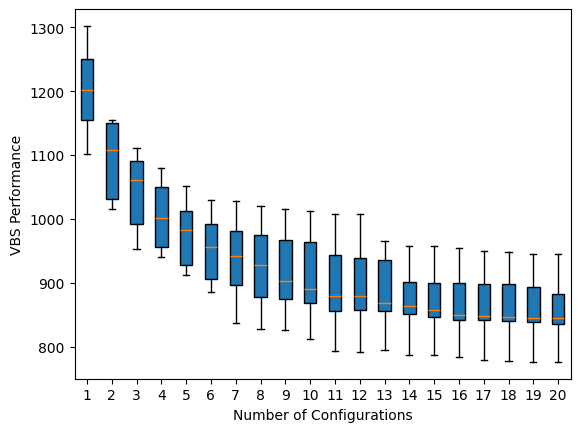

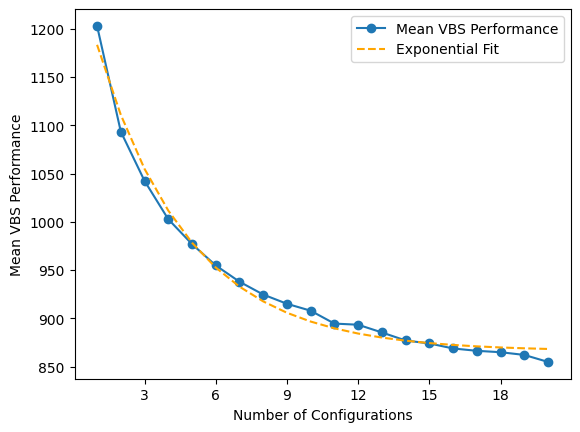

In [ ]:
from scipy.optimize import curve_fit
import numpy as np

for i in range(1, 20):
    print(i)    
    print(sum(perf[i])/len(perf[i]))
    print((1 - (sum(perf[i])/len(perf[i])) / (sum(perf[i - 1])/len(perf[i - 1]))) * 100)

plt.boxplot(perf, positions=range(1, 21), patch_artist=True, meanline=True)
plt.xlabel("Number of Configurations")
plt.ylabel("VBS Performance")
plt.show()

means = [sum(p)/len(p) for p in perf]
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit an exponential function to the VBS data
x_data = np.arange(1, 21)
y_data = means
params, _ = curve_fit(exponential_func, x_data, y_data, p0=(1200, 0.1, 800))
fitted_y = exponential_func(x_data, *params)

plt.plot(range(1, 21), means, marker='o', label="Mean VBS Performance")
plt.xlabel("Number of Configurations")
plt.ylabel("Mean VBS Performance")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.plot(x_data, fitted_y, label="Exponential Fit", linestyle="--", color="orange")
plt.legend()
plt.show()

In [2]:
import pickle
from helpers import *

with open('beamsearch/portfolios.pkl', 'rb') as f:
    results = pickle.load(f)
classifier_perf = [[] for _ in range(20)]

for i in range(10):
    print(i)
    features = get_available_features()

    data = get_prediction_dataset(features, "family")

    family_counts = data['family'].value_counts()
    families_to_replace = family_counts[family_counts < 5].index
    data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)

    data_train, data_test = train_test_split(data, test_size=0.2, random_state=i, stratify=data["family"])

    data_train['configuration'] = 'Default'
    for j in range(20):
        
        

        configs = results[i][j][0][0]
        
        for family in data_train['family'].unique():
            family_hashes = data_train.loc[data_train['family'] == family, 'hash'].tolist()
            data_train.loc[data_train['family'] == family, 'configuration'] = getBest(family_hashes, configs)

        rf = RandomForestClassifier()
        rf.fit(data_train[features], data_train['configuration'])   
        
        y_pred = rf.predict(data_test[features])

        insts = data_test['hash'].tolist()
        y_pred = rf.predict(data_test[features])
    
        predictions_df = pd.DataFrame(list(zip(data_test["hash"], y_pred)), columns=["hash", "predicted_index"])
    
        default = getDefault(insts)
        virtual = getVirtual(insts, configs)
        eval = evalConfigPredict(predictions_df)

        classifier_perf[j].append({
            'Default': default,
            'Virtual': virtual,
            'Eval': eval
        })

with open('beamsearch/classperf.pkl', 'wb') as f:
    pickle.dump(classifier_perf, f)


0
1
2
3
4
5
6
7
8
9


10


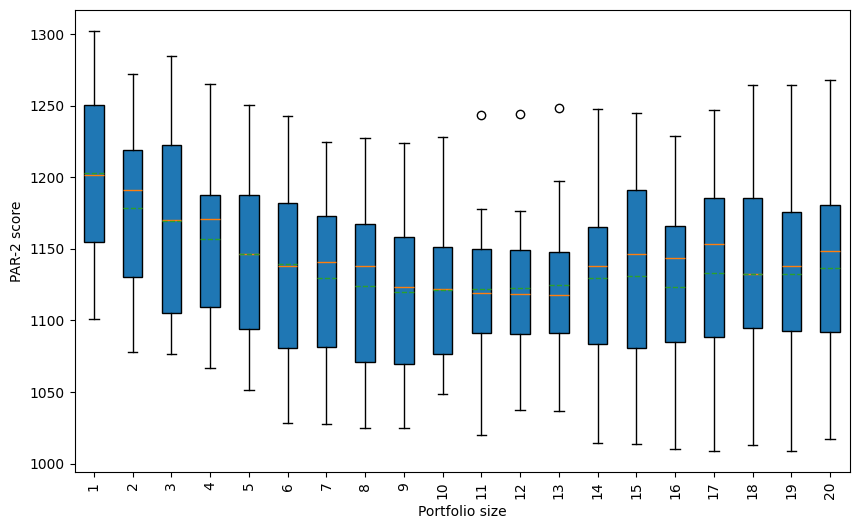

[1202.8876676468474, 1178.58384358679, 1169.5893069653134, 1156.9951270854785, 1146.353240029906, 1139.3216289946909, 1129.8791425504182, 1124.0468023105673, 1119.83456398531, 1120.9955167164928, 1122.020563792555, 1122.3648750345958, 1124.8538486625018, 1129.427525272338, 1131.116726497443, 1123.5654887539777, 1132.834070436578, 1132.6838571413568, 1132.5333926514575, 1136.9442731127926]


In [10]:
import pickle
import numpy as np
from helpers import *


with open('beamsearch/classperf.pkl', 'rb') as f:
    classifier_perf = pickle.load(f)

print(len(classifier_perf[0]))
compareModels(classifier_perf, names=[(i + 1) for i in range(20)])

means = [sum([perf['Eval'] for perf in perf_list]) / len(perf_list) for perf_list in classifier_perf]

print(means)

#plt.plot(range(1, 21), means, marker='o', label="Mean Evaluation Performance")
#plt.xlabel("Number of Configurations")
#plt.ylabel("Mean Evaluation Performance")
#plt.legend()
#plt.show()

#medians = [np.median((p["Eval"]) for p in sub) for sub in classifier_perf]
#
#plt.plot(range(1, 21), medians, marker='o', label="Median Evaluation Performance", color='orange')
#plt.xlabel("Number of Configurations")
#plt.ylabel("Median Evaluation Performance")
#plt.legend()
#plt.show()

In [1]:
from itertools import combinations
import pandas as pd
from helpers import *
import pickle

def pscore(train, solvers: list[str]):
    return getVirtual(train, solvers)

def pscores_all(train, solvers: list[str], k: int):
    return sorted([ (comb, pscore(train, list(comb))) for comb in combinations(solvers, k) ], key=lambda k : k[1])

def pscores_ext(train, solvers: list[str], tuples: list[tuple[str]]):
    tupset = set(frozenset(comb + (s,)) for comb in tuples for s in solvers if s not in comb)
    return sorted([(tuple(comb), pscore(train, list(comb))) for comb in tupset ], key=lambda k : k[1])

def beamsearch(beam_width, depth):
    df = pd.read_csv('top40.csv')
    configs = df['configuration'].drop_duplicates().tolist()

    features = get_available_features()

    data = get_prediction_dataset(features, "family")

    family_counts = data['family'].value_counts()
    families_to_replace = family_counts[family_counts < 5].index

    data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)

    data_train = data

    hashes = data_train['hash'].tolist()


    p = pscores_all(hashes, configs, 1)[:beam_width]
    portfolios = [p.copy()]
    for i in range(depth - 1):
        print(i)
        p = pscores_ext(hashes, configs, [tup[0] for tup in p])[:beam_width]
        print(p)
        portfolios.append(p.copy())
    return portfolios




result = beamsearch(10,9)

0
[(("{'backbone': 0, 'bump': 1, 'chrono': 1, 'congruence': 0, 'eliminate': 0, 'extract': 0, 'factor': 1, 'fastel': 1, 'forward': 1, 'lucky': 1, 'phase': 1, 'phasesaving': 1, 'preprocess': 1, 'probe': 1, 'randec': 0, 'reluctant': 0, 'reorder': 2, 'rephase': 0, 'restart': 1, 'stable': 0, 'substitute': 1, 'sweep': 1, 'target': 0, 'transitive': 0, 'vivify': 1, 'warmup': 0}", 'Default'), 1121.966300015393), (("{'backbone': 2, 'bump': 1, 'chrono': 0, 'congruence': 1, 'eliminate': 1, 'extract': 0, 'factor': 0, 'fastel': 1, 'forward': 0, 'lucky': 1, 'phase': 0, 'phasesaving': 1, 'preprocess': 0, 'probe': 1, 'randec': 0, 'reluctant': 0, 'reorder': 2, 'rephase': 1, 'restart': 1, 'stable': 0, 'substitute': 1, 'sweep': 1, 'target': 0, 'transitive': 1, 'vivify': 1, 'warmup': 1}", 'Default'), 1121.979472448075), (('Default', "{'backbone': 1, 'bump': 1, 'chrono': 1, 'congruence': 0, 'eliminate': 1, 'extract': 1, 'factor': 0, 'fastel': 1, 'forward': 1, 'lucky': 0, 'phase': 1, 'phasesaving': 1, 'prepr

In [8]:
print(result[-1][0][1])

910.919825103129
